In [35]:
import wget

url = 'https://raw.githubusercontent.com/EvilAura123/lab3/refs/heads/main/wine.data'
filename = wget.download(url)
print(filename)

100% [................................................................................] 7874 / 7874wine.data


In [37]:
import pandas as pd
import numpy as np

data_source = 'wine.data'
d = pd.read_table(data_source, delimiter=',',
                  header=None,
                  names=['Alcohol','Malicacid',
                         'Ash','Alcalinity_of_ash','Magnesium',
                        'Total_phenols','Flavanoids','Nonflavanoid_phenols',
                        'Proanthocyanins','Color_intensity','Hue',
                        '0D280_0D315_of_diluted_wines','Proline','Color'])
d.head()

,Alcohol,Malicacid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,0D280_0D315_of_diluted_wines,Proline,Color
1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,white
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,red
1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,white
1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,red
1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,white


In [38]:
d.info()

<class 'pandas.core.frame.DataFrame'>
Index: 115 entries, 1 to 3
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Alcohol                       115 non-null    float64
 1   Malicacid                     115 non-null    float64
 2   Ash                           115 non-null    float64
 3   Alcalinity_of_ash             115 non-null    float64
 4   Magnesium                     115 non-null    int64  
 5   Total_phenols                 115 non-null    float64
 6   Flavanoids                    115 non-null    float64
 7   Nonflavanoid_phenols          115 non-null    float64
 8   Proanthocyanins               115 non-null    float64
 9   Color_intensity               115 non-null    float64
 10  Hue                           115 non-null    float64
 11  0D280_0D315_of_diluted_wines  115 non-null    float64
 12  Proline                       115 non-null    int64  
 13  Color       

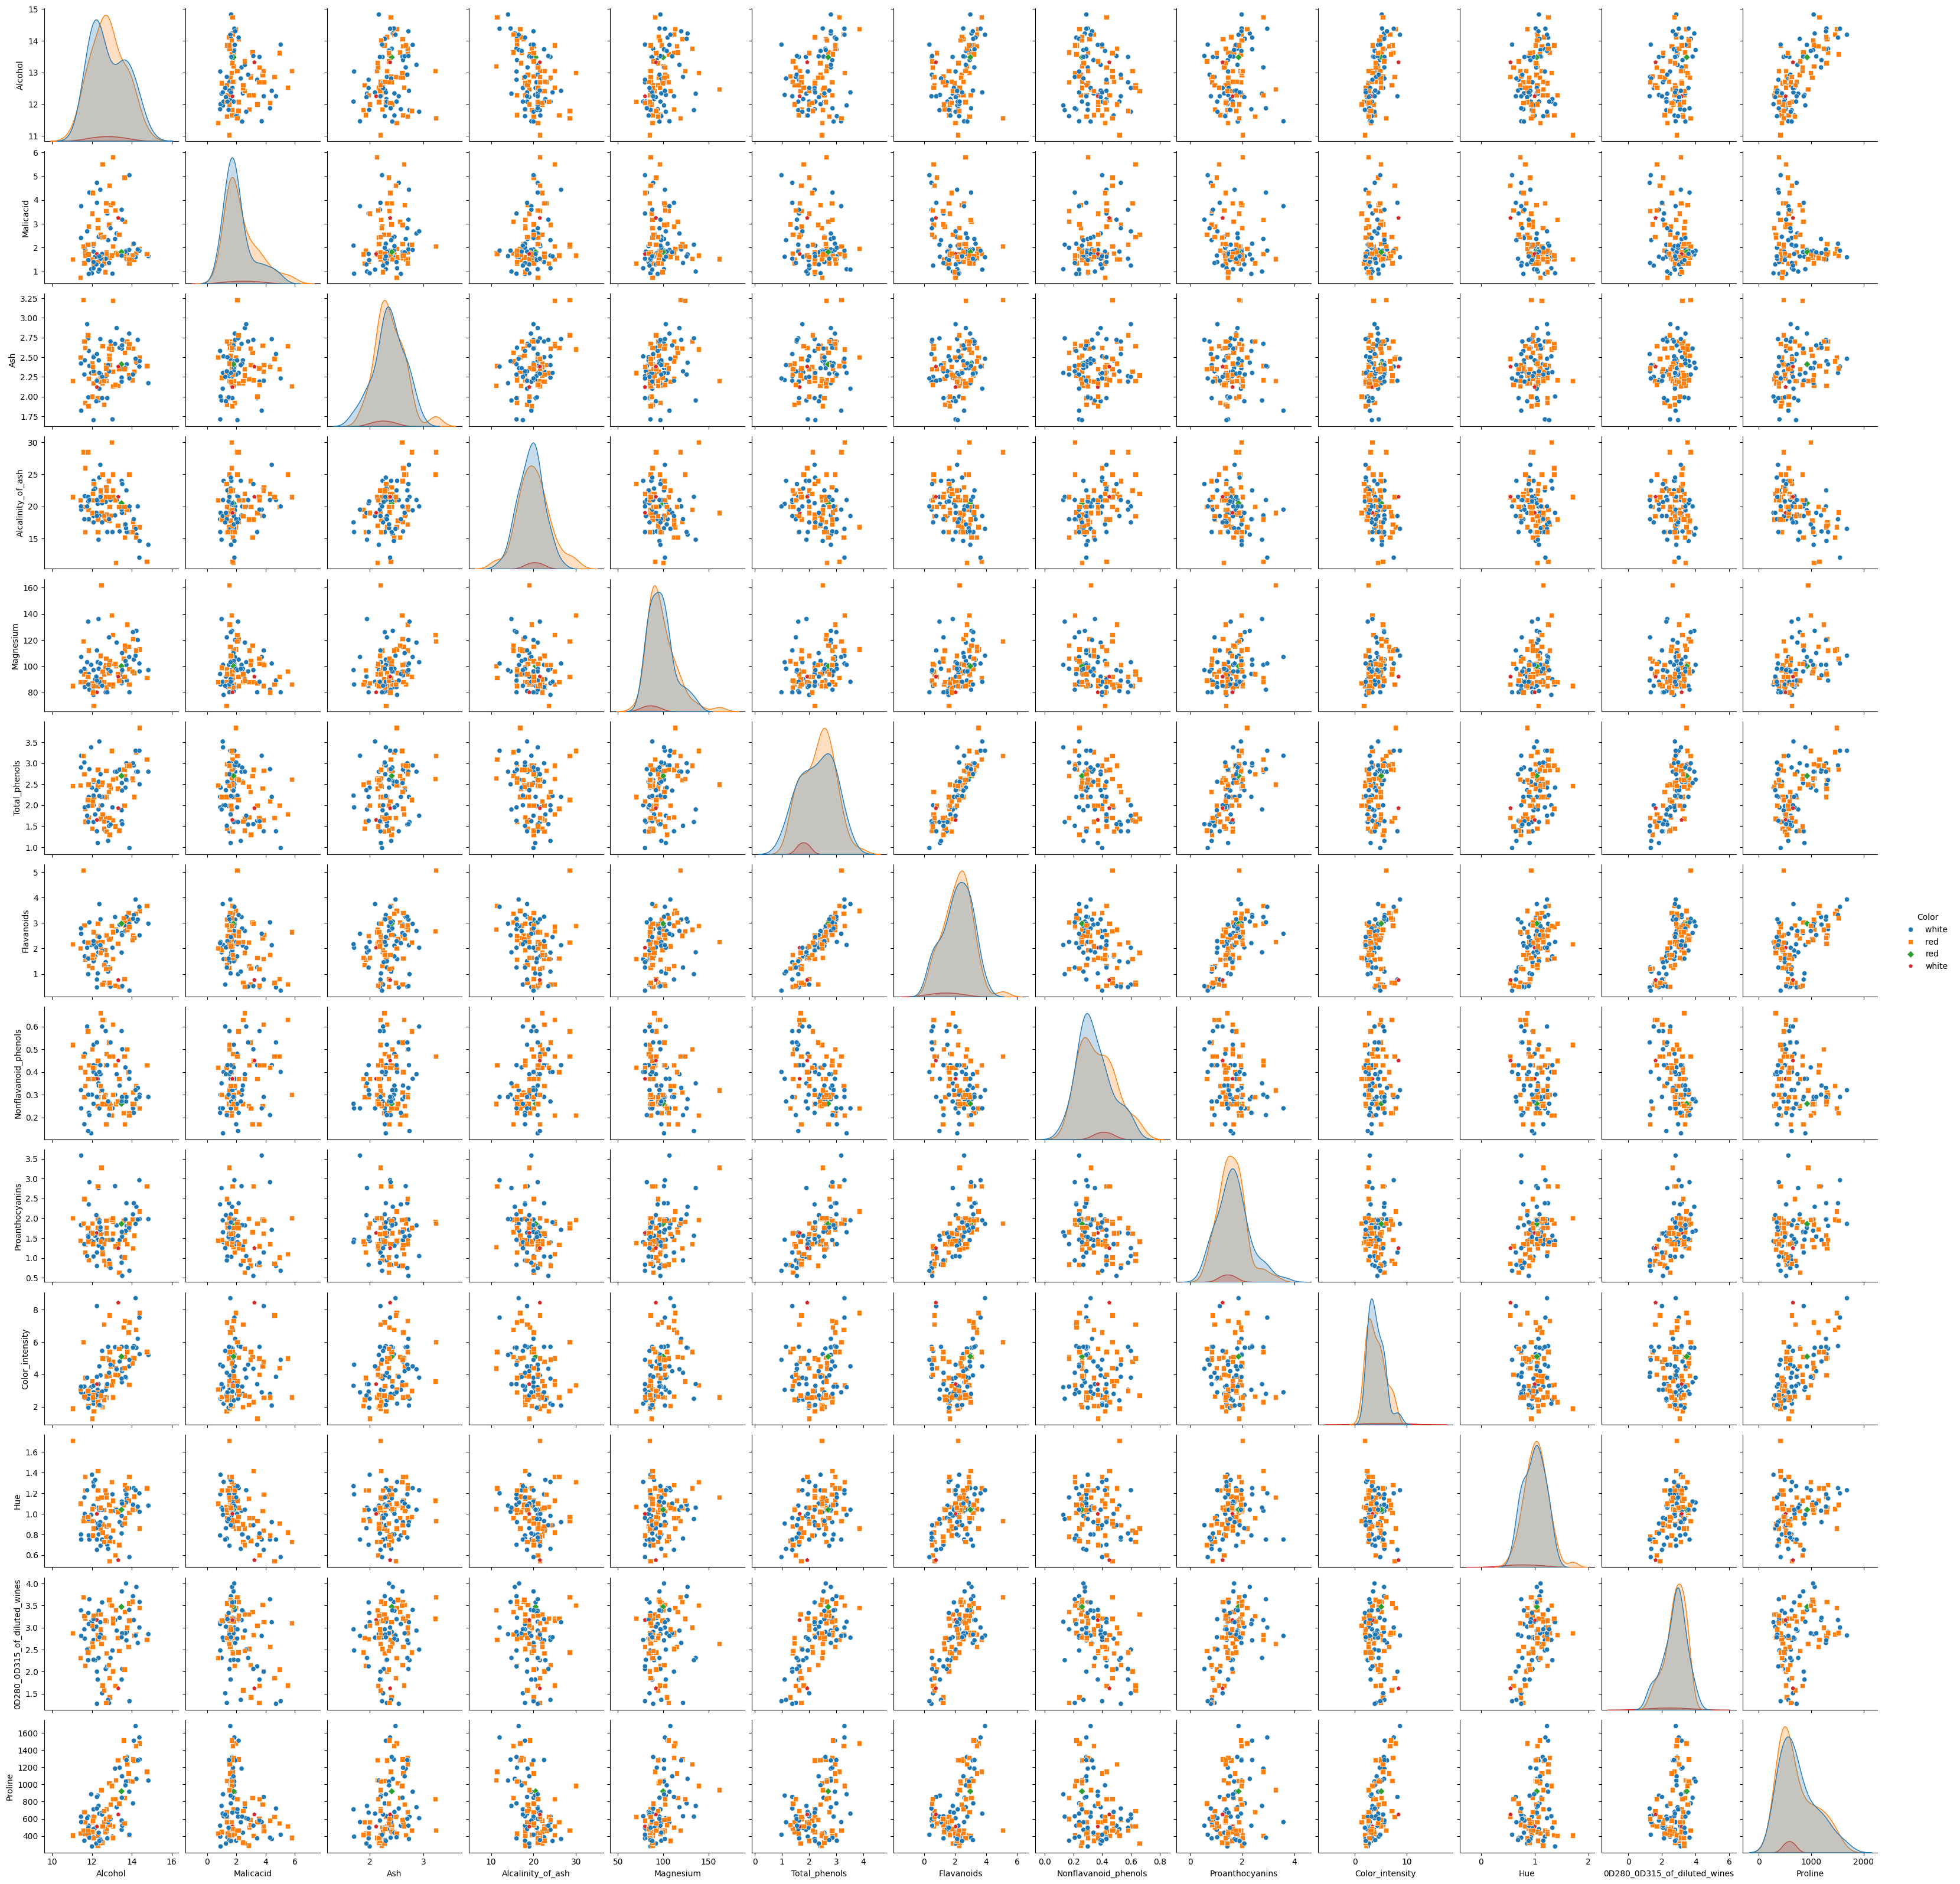

In [44]:
import seaborn as sb
%matplotlib inline
sb.pairplot(d, hue='Color', markers=["o", "s","D", "p"])

In [53]:
from sklearn.neighbors import KNeighborsClassifier

X_train = d[['Alcohol', 'Malicacid', 'Ash', 'Alcalinity_of_ash', 'Magnesium', 'Total_phenols', 'Flavanoids', 'Nonflavanoid_phenols',
            'Proanthocyanins', 'Color_intensity', 'Hue', '0D280_0D315_of_diluted_wines', 'Proline']]
y_train = d['Color']

K = 13

knn = KNeighborsClassifier(n_neighbors=K)
knn.fit(X_train.values, y_train)

X_test = np.array([[3.13, 32.3, 24.8, 21.5, 86, 1.7, 65, 47, 86.7, 65, 0.5, 51.2, 625]])
target = knn.predict(X_test)
print(target)

['white  ']


In [55]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_holdout, y_train, y_holdout = train_test_split(
    d.iloc[ :, 0:4 ],
    d['Color'],
    test_size=0.3,
    random_state=17)
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_holdout)
accur = accuracy_score(y_holdout, knn_pred)
print('accuracy: ', accur)

accuracy:  0.42857142857142855


Количество образцов в каждом классе:
Color
white      56
red        56
white       2
red         1
Name: count, dtype: int64


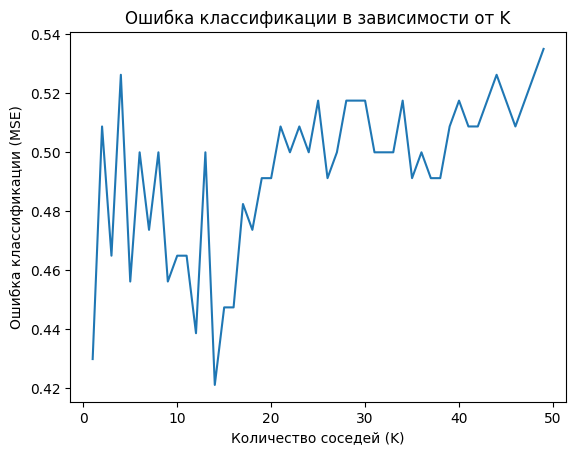

Оптимальные значения K:  [14]


In [66]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

# Проверяем распределение классов
class_counts = d['Color'].value_counts()
print('Количество образцов в каждом классе:')
print(class_counts)

# Удаляем классы с менее чем 2 образцами
valid_classes = class_counts[class_counts >= 2].index
filtered_data = d[d['Color'].isin(valid_classes)]

# Проверяем, достаточно ли классов осталось
if filtered_data['Color'].nunique() < 2:
    raise ValueError("Недостаточно классов для выполнения кросс-валидации.")

k_list = list(range(1, 50))
cv_scores = []

# Устанавливаем количество разбиений
cv_splits = 2  

# Проверяем, достаточно ли образцов для выполнения разбиения
if len(filtered_data) < cv_splits * 2:  
    raise ValueError("Недостаточно образцов для выполнения кросс-валидации.")

stratified_kf = StratifiedKFold(n_splits=cv_splits)

for K in k_list:
    knn = KNeighborsClassifier(n_neighbors=K)
    scores = cross_val_score(knn, filtered_data.iloc[:, :13], filtered_data['Color'], cv=stratified_kf, scoring='accuracy')
    cv_scores.append(scores.mean())

MSE = [1 - x for x in cv_scores]

plt.plot(k_list, MSE)
plt.xlabel('Количество соседей (K)')
plt.ylabel('Ошибка классификации (MSE)')
plt.title('Ошибка классификации в зависимости от K')
plt.show()

# Определение оптимальных значений K
k_min = min(MSE)
all_k_min = [k for k, mse in zip(k_list, MSE) if mse == k_min]

print('Оптимальные значения K: ', all_k_min)

In [67]:
print(sorted(list(plt.colormaps)))

['Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Grays', 'Grays_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'berlin', 'berlin_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cr

C:\Users\1\AppData\Local\Temp\ipykernel_25772\2696148104.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  xx, yy = np.meshgrid(np.arange(fmin[i], fmax[i], plot_step),
C:\Users\1\AppData\Local\Temp\ipykernel_25772\2696148104.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.arange(fmin[j], fmax[j], plot_step))
C:\Users\1\AppData\Local\Temp\ipykernel_25772\2696148104.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  xx, y

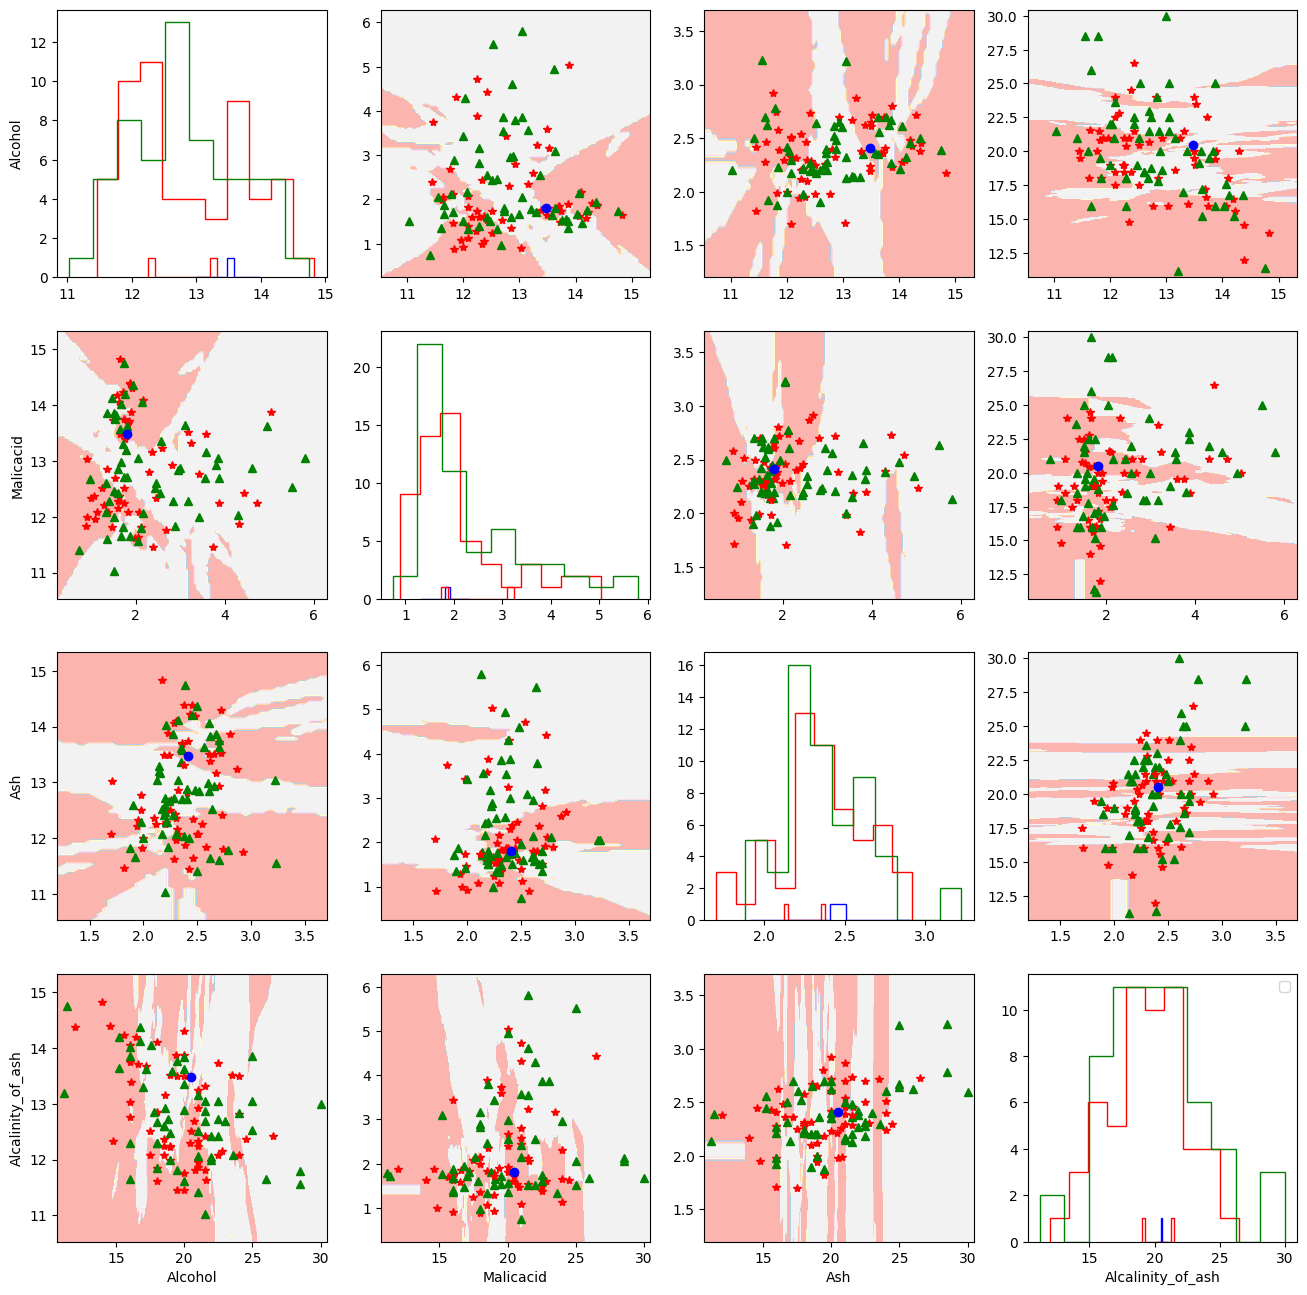

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

dX = d.iloc[:, 0:13]
dy = d['Color']

plot_markers = ['r*', 'g^', 'bo']
answers = dy.unique()

f, places = plt.subplots(4, 4, figsize=(16, 16))

fmin = dX.min() - 0.5
fmax = dX.max() + 0.5
plot_step = 0.05

for i in range(0, 4):
    for j in range(0, 4):
        if i != j:
            xx, yy = np.meshgrid(np.arange(fmin[i], fmax[i], plot_step),
                                 np.arange(fmin[j], fmax[j], plot_step))
            model = KNeighborsClassifier(n_neighbors=13)
            model.fit(dX.iloc[:, [i, j]].values, dy)
            p = model.predict(np.c_[xx.ravel(), yy.ravel()])
            p = p.reshape(xx.shape)

            # Замените классы на целочисленные значения
            for index, answer in enumerate(answers):
                p[p == answer] = index
            p = p.astype('int32')
            places[i, j].contourf(xx, yy, p, cmap='Pastel1')

        for id_answer in range(len(answers)):
            idx = np.where(dy == answers[id_answer])
            if i == j:
                places[i, j].hist(dX.iloc[idx].iloc[:, i],
                                   color=plot_markers[id_answer % len(plot_markers)][0],
                                   histtype='step')
            else:
                places[i, j].plot(dX.iloc[idx].iloc[:, i], dX.iloc[idx].iloc[:, j],
                                  plot_markers[id_answer % len(plot_markers)],
                                  label=answers[id_answer], markersize=6)

        if j == 0:
            places[i, j].set_ylabel(dX.columns[i])

        if i == 3:
            places[i, j].set_xlabel(dX.columns[j])

plt.legend()
plt.show()